# Linear Frequency Modulated (LFM) Impulses Part 2: Pulse Compression, Range Sidelobes, ordinary LFM vs Hamming weighted

[![nbviewer](https://raw.githubusercontent.com/jupyter/design/master/logos/Badges/nbviewer_badge.svg)](https://nbviewer.org/github/olddudealex/rf-notebooks/blob/main/pulse-modulation_pt2.ipynb) [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/olddudealex/rf-notebooks/blob/main/pulse-modulation_pt2.ipynb) [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/olddudealex/rf-notebooks/HEAD?labpath=pulse-modulation_pt2.ipynb)

In previous part we've looked at the spectrum of Linear Chirp. Now we will focus on the Pulse Compression technique and effect of time domain side lobes, that is highly not desirable in radar applications.

## Pulse Compression, Time Side Lobes, Spectrum Ripples Impact
Another disadvantage that could have the pure LFM signal (without amplitude windowing) is the side lobes in time domain due to high spectrum ripples.
Let's first see the pulse-compression of the chirp in ideal circumstances (no added noise, the amplitude of reflected signal is the same). We will use now only one signal of 1us length and 10Mhz dF.

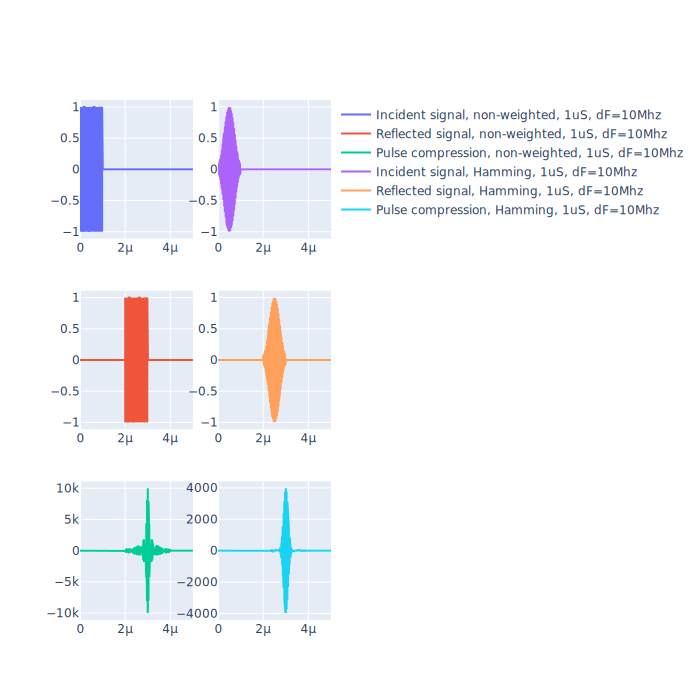

In [1]:
import plotly.io as pio

# The next line is a special one for auto-generation of static page version.
static_rendering = True
if static_rendering:
  pio.renderers.default = "svg"
  import sys
  import os
  parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
  sys.path.insert(0, parent_dir)
elif 'google.colab' in str(get_ipython()):
  %cd /content
  !rm -rf rf-notebooks
  !git clone -q -s https://github.com/olddudealex/rf-notebooks/ rf-notebooks
  %cd rf-notebooks
  pio.renderers.default = "colab"
  print("The colab renderer is used")
else:
  pio.renderers.default = "plotly_mimetype+notebook"
  print("The notebook renderer is used")

import plot_data as pd
import numpy as np
from plotly.subplots import make_subplots
import plotly.graph_objects as go

sim_dur = 5000*(10**(-9))
tu = 5*(10**(-11))

s_ind = pd.LfmSignal(f0=3*(10**9), delta_f=10*(10**6), tu=tu,
                     l_sec=1000*(10**(-9)), s_sec=0, sim_dur=sim_dur)
reflected_signal = np.roll(s_ind.sig.data, s_ind.L * 2)
pulse_compression = np.convolve(s_ind.sig.data, np.flip(reflected_signal))

s_ind_h = pd.LfmSignal(f0=3*(10**9), delta_f=10*(10**6), tu=tu,
                       l_sec=1000*(10**(-9)), s_sec=0, sim_dur=sim_dur)
s_ind_h.sig.data[:s_ind_h.L] = np.hamming(s_ind_h.L) * s_ind_h.sig.data[:s_ind_h.L]
reflected_signal_h = np.roll(s_ind_h.sig.data, s_ind_h.L * 2)
pulse_compression_h = np.convolve(s_ind_h.sig.data, np.flip(reflected_signal_h))

fig = make_subplots(rows=3, cols=2)
fig.add_trace(go.Scatter(x=np.linspace(0, sim_dur, s_ind.sig.data.size),
                         y=s_ind.sig.data,
                         name=f"Incident signal, non-weighted, 1uS, dF=10Mhz"), row=1, col=1)
fig.add_trace(go.Scatter(x=np.linspace(0, sim_dur, s_ind.sig.data.size),
                         y=reflected_signal,
                         name=f"Reflected signal, non-weighted, 1uS, dF=10Mhz"), row=2, col=1)
fig.add_trace(go.Scatter(x=np.linspace(0, sim_dur, s_ind.sig.data.size),
                         y=pulse_compression[0:s_ind.sig.data.size],
                         name=f"Pulse compression, non-weighted, 1uS, dF=10Mhz"), row=3, col=1)

fig.add_trace(go.Scatter(x=np.linspace(0, sim_dur, s_ind_h.sig.data.size),
                         y=s_ind_h.sig.data,
                         name=f"Incident signal, Hamming, 1uS, dF=10Mhz"), row=1, col=2)
fig.add_trace(go.Scatter(x=np.linspace(0, sim_dur, s_ind_h.sig.data.size),
                         y=reflected_signal_h,
                         name=f"Reflected signal, Hamming, 1uS, dF=10Mhz"), row=2, col=2)
fig.add_trace(go.Scatter(x=np.linspace(0, sim_dur, s_ind_h.sig.data.size),
                         y=pulse_compression_h[0:s_ind_h.sig.data.size],
                         name=f"Pulse compression, Hamming, 1uS, dF=10Mhz"), row=3, col=2)

fig.update_layout(hovermode='x unified', height=700)
fig.update_xaxes(exponentformat="SI")
fig.show()

Let's scale up the pulse compression results:

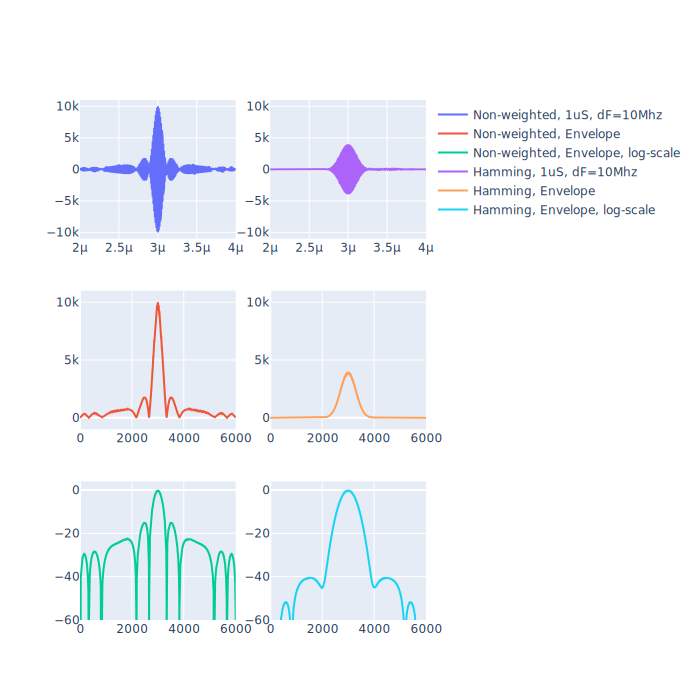

In [2]:
start = int(2*(10**(-6))/s_ind.sig.tu)
end = int(4*(10**(-6))/s_ind.sig.tu)

# idea of it is from https://stackoverflow.com/questions/34235530/how-to-get-high-and-low-envelope-of-a-signal
def get_envelope(s):
    max_ind = (np.diff(np.sign(np.diff(s))) < 0).nonzero()[0] + 1
    max_env = [s[i] for i in max_ind]
    return max_ind, max_env

fig = make_subplots(rows=3, cols=2)
fig.add_trace(go.Scatter(x=np.linspace(0, sim_dur, s_ind.sig.data.size)[start:end],
                         y=pulse_compression[start:end],
                         name=f"Non-weighted, 1uS, dF=10Mhz"), row=1, col=1)
pc_envelope = get_envelope(pulse_compression[start:end])[1]
pc_envelope = [x if x > 0 else 0.000001 for x in pc_envelope]
fig.add_trace(go.Scatter(y=pc_envelope,
                         name=f"Non-weighted, Envelope"), row=2, col=1)
fig.add_trace(go.Scatter(y=20*np.log10(pc_envelope/np.max(pc_envelope)),
                         name=f"Non-weighted, Envelope, log-scale"), row=3, col=1)

fig.add_trace(go.Scatter(x=np.linspace(0, sim_dur, s_ind_h.sig.data.size)[start:end],
                         y=pulse_compression_h[start:end],
                         name=f"Hamming, 1uS, dF=10Mhz"), row=1, col=2)
pc_envelope_h = get_envelope(pulse_compression_h[start:end])[1]
pc_envelope_h = [x if x > 0 else 0.000001 for x in pc_envelope_h]
fig.add_trace(go.Scatter(y=pc_envelope_h,
                         name=f"Hamming, Envelope"), row=2, col=2)
fig.add_trace(go.Scatter(y=20*np.log10(pc_envelope_h/np.max(pc_envelope_h)),
                         name=f"Hamming, Envelope, log-scale"), row=3, col=2)

fig.update_layout(hovermode='x unified', height=700)
fig.update_yaxes(range = [-11000, 11000], row=1)
fig.update_yaxes(range = [-1000, 11000], row=2)
fig.update_yaxes(range = [-60, 4], row=3)
fig.update_xaxes(exponentformat="SI")
fig.show()

You can see the ordinary linear chirp on the left and Hamming weighted to the right. The main result - Hamming decreases the absolute dynamic range and the sensitivity, but could also help a lot with reducing side lobes.

## References

1. Chirp spectrum. (2024, November 11). In *Wikipedia*. Retrieved November 11, 2024, from https://en.wikipedia.org/wiki/Chirp_spectrum
